In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 8)
# we use regex here to parse the output log files
import re

Populating the interactive namespace from numpy and matplotlib


In [2]:
# global variables
FOLDER_PREFIX="resnet_test_gpu_worker"

worker_num_interval = [2, 4, 8, 16, 32, 64]
# single node means, we have single worker node in cluster (ps+worker0)
single_node_time=765.886
# signle machine means we only consider training on local machine, thus there is no communication cost
single_machine_time=697.278

In [10]:
global_dict_saver = []
for num_w in worker_num_interval:
    # master is also include in this one, so the first worker should be the master
    time_stats_dict = {}
    for worker_index in range(num_w):
        if worker_index == 0:
            out_file=open(FOLDER_PREFIX+str(num_w)+'/out_master', 'rb')
        else:
            # for the case of 8 workers, we only consider master, worker0,...,worker6
            out_file=open(FOLDER_PREFIX+str(num_w)+'/out_worker_'+str(worker_index-1), 'rb')
        for line in out_file.readlines():
            line_string = line.rstrip('\n')
            search_sth = re.match('INFO:tensorflow:Worker(.*): (.*): step (.*), loss = (.*).* examples/sec; (.*) sec/batch.*', line_string)
            if search_sth:
                worker_index, cur_step, worker_time_cost = int(search_sth.group(1)), int(search_sth.group(3)), float(search_sth.group(5))
                if cur_step <= 300:
                    #print(worker_index, cur_step, worker_time_cost)
                    if cur_step not in time_stats_dict.keys():
                        time_stats_dict[cur_step]=[worker_time_cost]
                    else:
                        time_stats_dict[cur_step].append(worker_time_cost)
    global_dict_saver.append(time_stats_dict)

pdf_saver = []
range_saver = []

for dict_idx, stat_dict in enumerate(global_dict_saver):
    counter_list = [0]*worker_num_interval[dict_idx]
    range_tmp = [i+1 for i in range(worker_num_interval[dict_idx])]
    for k, v in stat_dict.iteritems():
        sorted_v = sorted(v)
        for c_i, _ in enumerate(counter_list):
            counter_list[c_i] += sorted_v[c_i]
    print(counter_list)
    print(range_tmp)
    pdf_saver.append(counter_list)
    range_saver.append(range_tmp)
    print
    #print("Cluster set up with {} workers: ideal time: {} full time:{}".format(worker_num_interval[dict_idx], ideal_counter_, full_counter_))
   

[327.102, 354.6510000000001]
[1, 2]

[162.21999999999997, 166.986, 177.96899999999997, 207.48099999999994]
[1, 2, 3, 4]

[85.24199999999996, 85.90999999999995, 91.51599999999995, 92.41199999999999, 103.68700000000007, 104.013, 107.49300000000007, 116.55700000000027]
[1, 2, 3, 4, 5, 6, 7, 8]

[66.17699999999994, 66.7749999999999, 68.89799999999988, 69.23499999999989, 69.3509999999999, 69.48399999999991, 72.21799999999985, 72.44399999999987, 72.6599999999999, 73.5699999999999, 75.01399999999988, 75.2479999999999, 76.97299999999989, 80.94799999999988, 82.6859999999999, 91.50799999999988]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

[69.56199999999998, 76.60899999999997, 80.53800000000001, 82.83000000000003, 86.26500000000004, 88.98999999999998, 93.22500000000007, 94.86900000000001, 100.58800000000002, 101.92999999999999, 107.82300000000002, 108.41399999999999, 108.98699999999997, 109.63799999999999, 111.037, 111.44399999999997, 112.27199999999999, 112.79600000000003, 115.38200

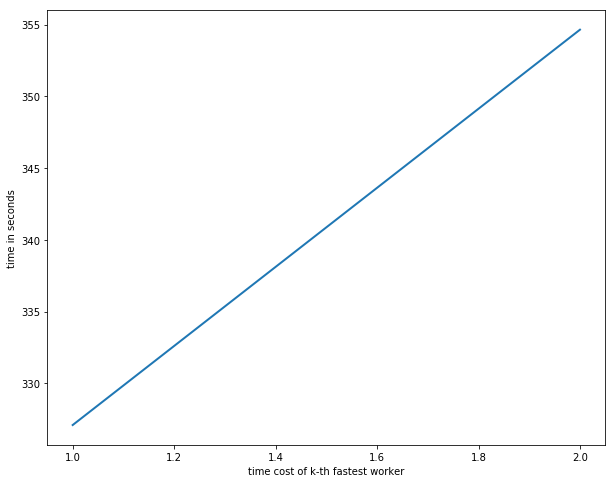

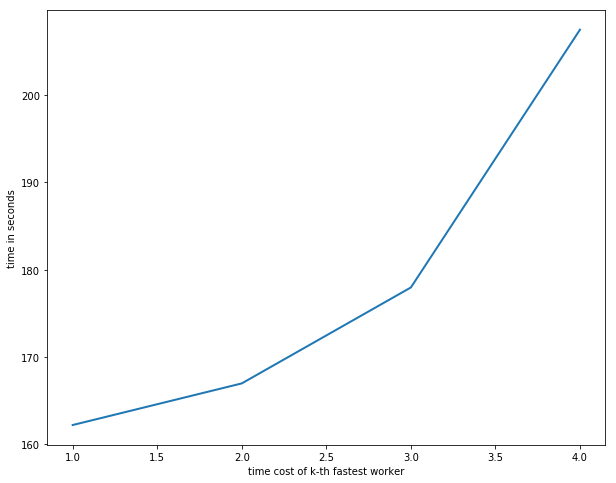

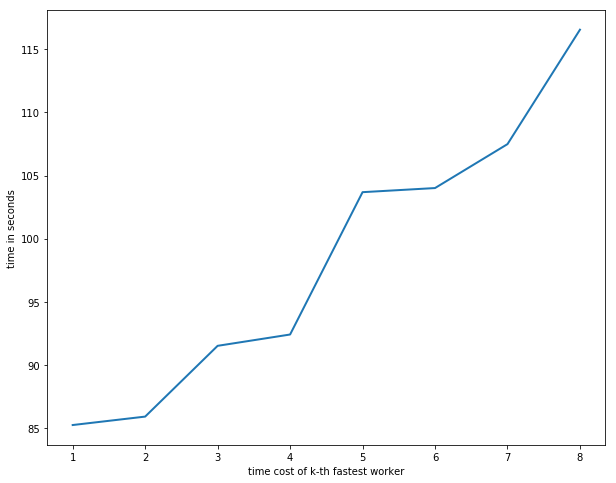

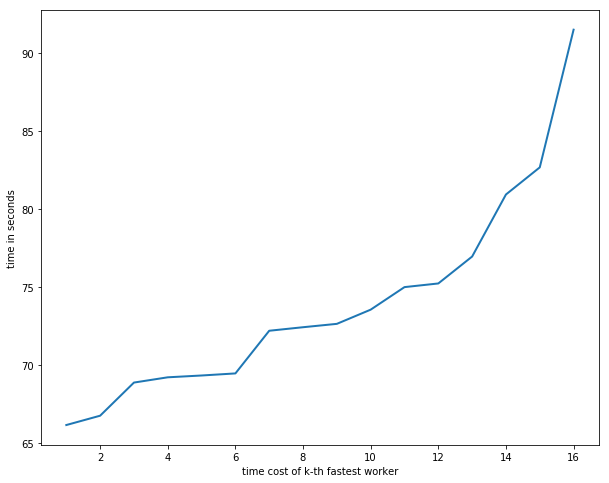

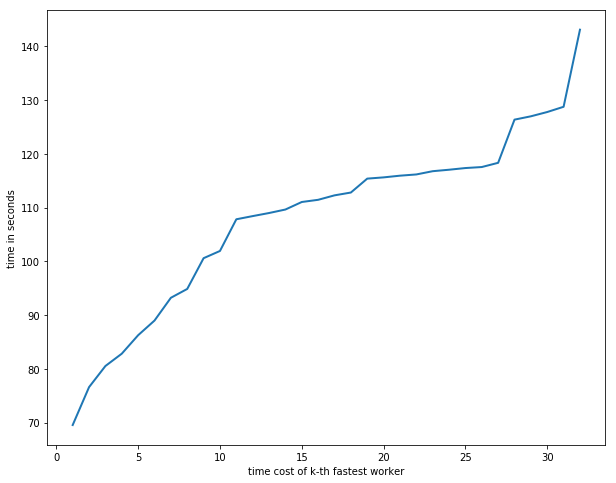

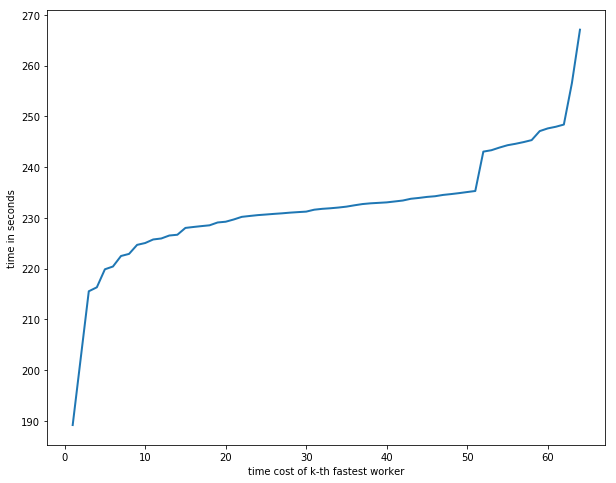

In [13]:
for i in range(len(range_saver)):
    fig = plt.figure()
    plt.plot(range_saver[i], pdf_saver[i], linewidth=2)
    plt.xlabel("time cost of k-th fastest worker")
    plt.ylabel("time in seconds")
plt.show()